## PART6. 딥러닝을 이용한 주가 예측

    - 사용할 주식 데이터: 삼성전자 액면분할 상장일이던  2018.5.4 ~ 2020.1.22까지의 OHLVC 데이터
    - 70% 훈련용 / 30% 테스트용 
    - 학습을 통해 모델 완성되면, 예측된 종가와 실제 종가를 그래프로 그려서 비교 진행 

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import matplotlib.pyplot as plt

from investar import Analyzer

#### 6.1 데이터 조회 및 확인
    1. 사용할 데이터를 구현한 시세 조회 API를 통해 조회한다.
    2. 숫자 단위가 클수록 계산에 소요되는 시간이 늘어나므로 데이터를  0~1 사이 작은 단위로 정규화 진행해 시간 단축한다.
    

In [14]:
mk = Analyzer.MarketDB()
raw_df = mk.get_daily_price('삼성전자', '2020-01-23', '2022-07-04')            # 1. 

window_size = 10 # 이전 10일동안 데이터를 통해 종가 예측
data_size = 5 

def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)                                   # 2. 

dfx = raw_df[['open','high','low','volume', 'close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['close']]

x = dfx.values.tolist()
y = dfy.values.tolist()

In [15]:
raw_df

,code,date,open,high,low,close,diff,volume
date,,,,,,,,
2020-01-23,005930,2020-01-23,61800,61800,60700,60800,1500,14916555
2020-01-28,005930,2020-01-28,59400,59400,58300,58800,2000,23664541
2020-01-29,005930,2020-01-29,59100,59700,58800,59100,300,16446102
2020-01-30,005930,2020-01-30,58800,58800,56800,57200,1900,20821939
2020-01-31,005930,2020-01-31,57800,58400,56400,56400,800,19749457
...,...,...,...,...,...,...,...,...
2022-06-27,005930,2022-06-27,59000,59900,58300,58800,400,18122236
2022-06-28,005930,2022-06-28,59200,59500,58700,59400,600,13540538
2022-06-29,005930,2022-06-29,58500,58800,58000,58000,1400,14677138


### 6.2 데이터셋 준비 
    - X: 이전 10일동안의 OHLVC 데이터 
    - Y: 다음 날의 종가 

In [16]:
data_x = []
data_y = []
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_x.append(_x)
    data_y.append(_y)
print(_x, "->", _y)

[[0.35220125786089684, 0.30704225352055015, 0.36228813559245276, 0.25377352668132414, 0.3567010309270996], [0.3605870020956801, 0.30704225352055015, 0.3347457627111552, 0.31539210646200394, 0.33402061855601234], [0.33752620545002615, 0.29389671361447156, 0.3368644067789473, 0.20619574550699657, 0.32989690721581466], [0.34381551362611357, 0.29201877934217463, 0.3241525423721946, 0.18410328415913696, 0.3113402061849251], [0.316561844863068, 0.27136150234690826, 0.3072033898298576, 0.2450647874828217, 0.3072164948447274], [0.32075471698045965, 0.29201877934217463, 0.3262711864399867, 0.18314591517245862, 0.3278350515457158], [0.34381551362611357, 0.30704225352055015, 0.33898305084673946, 0.12060131261301463, 0.33608247422611115], [0.34800838574350523, 0.29953051643136236, 0.3474576271179079, 0.06478364525673146, 0.34845360824670424], [0.33333333333263454, 0.2863849765252838, 0.3326271186433631, 0.07863055544530159, 0.31958762886532044], [0.3060796645695889, 0.26384976525772047, 0.31144067

### 6.3 훈련용 데이터셋, 테스트용 데이터셋 분리 
    과적합 현상을 방지하기 위해 데이터셋 분리한다. 
    학습 과정에서 사용된 적이 없는 테스트용 데이터셋을 분리해서 사용함으로써 학습의 객관성을 보증 및 점검한다. 

In [17]:
# Train
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])
# Test
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

### 6.4 모델 생성 및 학습
    - 학습: 훈련 데이터로부터 가중치 매개변수의 최적값을 자동으로 획득하는 것 
    - 학습의 목표: 손실 함수의 결과값을 가장 작게 만드는 가중치 매개변수를 찾는 것
    - 손실함수: 신경망이 학습할 수 있도록 해주는 지표
    
    실제로 학습과정에서 epoch이 증가할수록 손실 함수의 결괏값(loss)가 줄어드는 것을 확인 할 수 있다. 

In [19]:
model = Sequential()
model.add(LSTM(units=10, activation='relu', return_sequences=True, input_shape=(window_size, data_size)))
model.add(Dropout(0.1))
model.add(LSTM(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_x, train_y, epochs=200, batch_size=30)
pred_y = model.predict(test_x)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 10, 10)            640       
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 10)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 10)                840       
_________________________________________________________________
dropout_13 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,491
Trainable params: 1,491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2786
Epoch 2/200
14/14 [===================

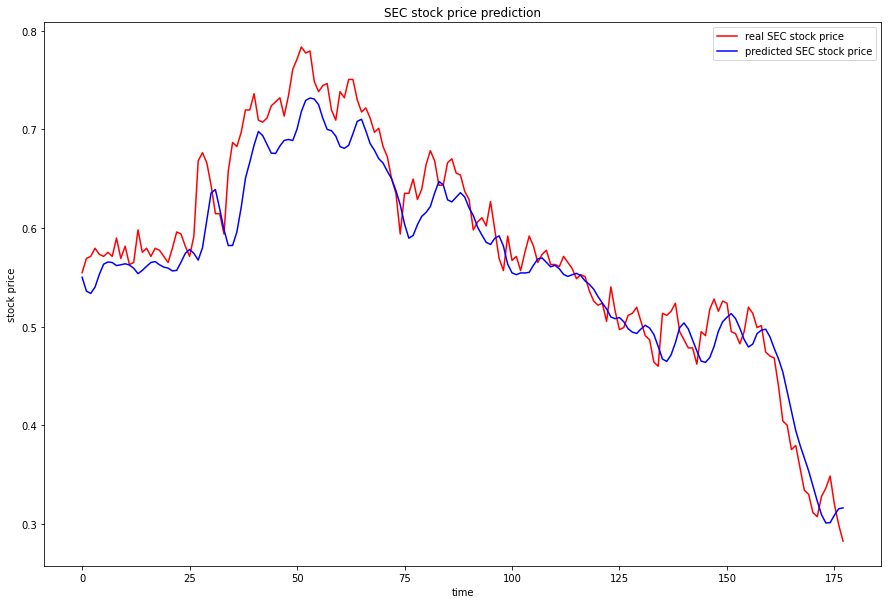

Tomorrow's SEC price : [62890.33] KRW


In [23]:
# Visualising the results
plt.figure(figsize=(15,10))
plt.plot(test_y, color='red', label='real SEC stock price')
plt.plot(pred_y, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# raw_df.close[-1] : dfy.close[-1] = x : pred_y[-1]
print("Tomorrow's SEC price :", raw_df.close[-1] * pred_y[-1] / dfy.close[-1], 'KRW')